In [1]:
# my modules imports
from modules.collisions_handler import CollisionHandler
from modules.particules import Particule
from modules.utils import segment
from modules.vector import MyVector
from modules.grid import Grid
from modules.utils import get_mass_part

# imports
from dolfin import Point
from random import random
import numpy as np
from scipy.stats import maxwell

#----------------- debug parameters --------------------#
debug = True
#----------------- physics property --------------------#

real_particle_density = 1e20 # for I2
effective_diameter = 4e-10 # roughly the diameter of I
max_speed = 4e3 # 4000 m/s we say ~> Maxwellian distribution

mean_free_path = 1/(np.sqrt(2)*np.pi*effective_diameter*effective_diameter*real_particle_density)
mean_free_time = mean_free_path/max_speed
dt = 0.25 * mean_free_time

mean_particles_number_per_cell = 50

MAX_INTEGRATION_STEP = 200
#----------------- Space properties --------------------#
# resolution along each previous dimension
res1, res2 = 10, 10

# rectangle of size l1*l2
l1,l2 = res1*mean_free_path,res2*mean_free_path

if(debug): print("Dimension : {}x{} m".format(round(l1,2),round(l2,2)))

l3 = 0.1 # 10 cm ?

#----------------- Grid creation ----------------------#

my_grid = Grid(l1,l2,[res1,res2], dtype = "DynamicArray")

#-------------- Particles properties -------------------#
IODINE_MASS = get_mass_part(53, 53, 88)

charge = 0
mass = IODINE_MASS
# pos = MyVector(0,0,0), speed = MyVector(0,0,0), 
part_type = "I"
radius = effective_diameter/2.0
verbose = False
# status = -1 # irrelevant


#--------------- Particles creation -------------------#
# TODO : add maxwellian distribution for speed

N_particles_real = int(real_particle_density*l1*l2*l3) # this is the REAL number of particles
N_particles_simu = int(mean_particles_number_per_cell*res1*res2)
Ne = int(N_particles_real/N_particles_simu)

if(debug): print("There is {} particles in the simulation. One particle account for {} real particles.".format("{:e}".format(N_particles_simu),"{:e}".format(Ne)))

# parameters of the maxwellian distribution
# https://stackoverflow.com/questions/63300833/maxwellian-distribution-in-python-scipy
σ = 300
μ = 3000

a = σ * np.sqrt(np.pi/(3.0*np.pi - 8.0))

m = 2.0*a*np.sqrt(2.0/np.pi)

loc = μ - m

list_particles=[]
for k in range(N_particles_simu):
    theta = random()*2*np.pi
    norm_speed = float(maxwell.rvs(loc, a))
    cTheta = float(np.cos(theta))
    sTheta = float(np.sin(theta))
    x, y = random(), random()
    while(x==0.0 or x==1.0):
        x=random()
    while(y==0.0 or y==1.0):
        y=random()  
    list_particles.append(Particule(charge = charge, radius = radius, 
        mass = mass, part_type = part_type, \
            speed=MyVector(norm_speed*cTheta,norm_speed*sTheta,0), \
                pos=MyVector(l1*random(),l2*random(),0), \
                    verbose = verbose))


#--------------- Rectangle creation -------------------#

rectangle_walls = [segment(Point(0,0),Point(0,l2)), segment(Point(0,0),Point(l1,0)), \
    segment(Point(l1,0),Point(l1,l2)), segment(Point(0,l2),Point(l1,l2))]

#---------- Adding particles to the grid -------------#
for particle in list_particles:
    my_grid.add(particle)

#---------- Creating collision handler ---------------#

    # update function
def f(Y,t,m,q):
    vx=Y[3]
    vy=Y[4]
    vz=Y[5]
    
    ax = 0 
    ay = 0
    az = 0
    return [vx, vy, vz, ax, ay, az]

    # parameters
eta = 0
p = 0

    # DSMC params

# /!\ explanation of the calculus of Ne /!\
"""
Density of I : [I] = n = 10e20
size of the system : l1*l2*l3 (here)
Number of particles in the real system :  [I2]*l1*l2*l3 (if we inject them, we can go straight to here with the number of particles injected)
Remember that : mean free path is 0.01 m. (𝜆=1/(√2𝜋𝜎²𝑛)) (𝜎 : effective diameter of the particles)
At max speed (no electromagnetic field, no acceleration) : 3400 m/s (Note : Maxwellian distribution.)
That yields here : 𝑀𝑒𝑎𝑛𝐹𝑟𝑒𝑒𝑇𝑖𝑚𝑒 ≈ 3×10−6 𝑠 which yields Δ ≤ 3×10−7 𝑠. Which is what we'll choose.
In addition, we have a particles-per-cell-target of : Nc_mean = 50 particles
Which yields : Number_of_cells = res1*res2*Nc_mean particles.

"""

DSMC_params = {
    'vr_max' : 2*max_speed,
    'effective_diameter':  effective_diameter,
    'Ne' : Ne, # this is the number of real particles one simulated particle represents.
    'cell_volume' : l1*l2*l3/(res1*res2) # since we are in 2D I don't really know what to add here actually... For now, I add the 3rd dimension rough size, that is l3
}

collisionHandler = CollisionHandler(list_particles, rectangle_walls, f, eta, p, use_particles_collisions = False, \
        use_DSMC = True, grid = my_grid, DSMC_params = DSMC_params)


Dimension : 0.14x0.14 m
There is 5.000000e+03 particles in the simulation. One particle account for 3.957859e+13 real particles.


In [2]:
if debug : print(my_grid.to_string())


Particules in the grid : 

Position in grid : [0, 0]
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.004,0.007) m with speed (2707.187,1066.308) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.005,0.007) m with speed (1086.308,-2312.138) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.005,0.003) m with speed (2774.782,2478.835) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.011,0.012) m with speed (3156.454,272.67) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.014,0.011) m with speed (-1287.796,2598.528) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.005,0.005) m with speed (-2664.63,43.149) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.003,0.014) m with speed (-2329.759,-1997.534) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.007,0.013) m with speed (-2948.391,-1036.929) m/s
I particule of c

I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.033,0.114) m with speed (-935.216,2884.07) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.032,0.113) m with speed (-1953.918,2101.808) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.033,0.114) m with speed (-2337.735,-2017.909) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.033,0.121) m with speed (-2584.371,-2213.326) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.038,0.125) m with speed (-2885.153,-1430.26) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.03,0.119) m with speed (2609.086,-2076.683) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.032,0.118) m with speed (997.716,3338.66) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.038,0.116) m with speed (2566.366,-1056.793) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.

I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.091,0.055) m with speed (-2807.319,-1637.31) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.087,0.056) m with speed (-2216.877,-1882.592) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.087,0.055) m with speed (-2257.602,-2320.697) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.089,0.044) m with speed (811.294,2806.84) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.095,0.047) m with speed (-1467.371,2216.236) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.098,0.052) m with speed (-2703.712,-2152.876) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.09,0.051) m with speed (250.766,-2878.339) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.093,0.054) m with speed (-507.792,3029.876) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0

I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.135,0.1) m with speed (1958.033,-3084.557) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.137,0.102) m with speed (3120.608,132.478) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.139,0.112) m with speed (940.31,2651.066) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.138,0.108) m with speed (-2343.199,1545.189) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.139,0.108) m with speed (-567.949,-2763.752) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.135,0.101) m with speed (-2243.408,1695.305) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.129,0.108) m with speed (-2612.372,2011.58) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.127,0.104) m with speed (2233.421,1953.526) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.127,0

In [3]:
# Animation function
def animate(i):
    t = dt*i
    collisionHandler.step(dt, t, [])
    
    X_pos = []
    Y_pos = []
    for k in range(len(list_particles)):
        X_pos.append(list_particles[k].get_2D_pos().x)
        Y_pos.append(list_particles[k].get_2D_pos().y)
    line.set_data(X_pos, Y_pos)
    return line,

Animation slowed ratio : 5.000000e+03


<IPython.core.display.Javascript object>


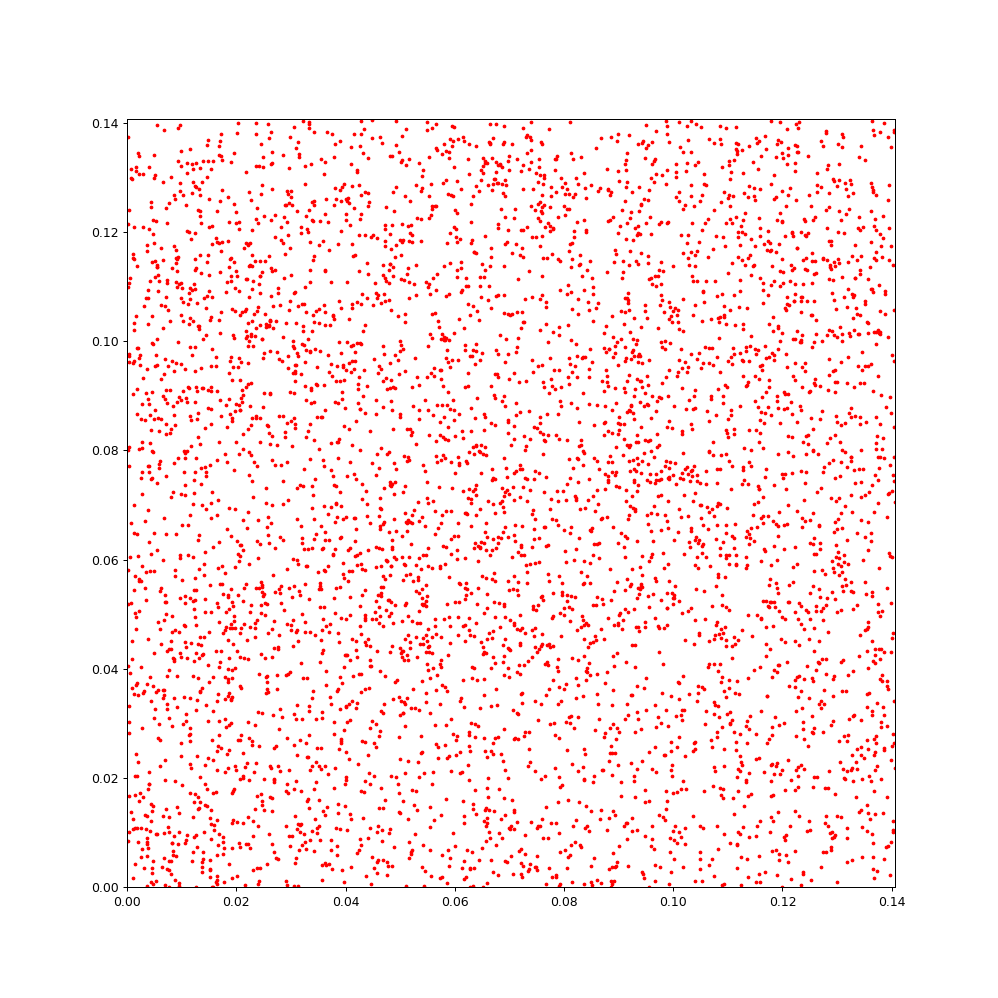

In [4]:
interval = 40 # ms, 25 images per second
print("Animation slowed ratio : {}".format("{:e}".format(interval/dt)))
# Animating
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure(figsize=(10,10))
# TODO : ajouter le plot des murs
ax = fig.add_subplot(111, aspect='equal')
line, = ax.plot([], [], 'ro', ms=2)
ax.set_xlim(0,l1)
ax.set_ylim(0,l2)
anim = animation.FuncAnimation(fig, animate, interval = interval, frames = MAX_INTEGRATION_STEP, blit=False, \
                              save_count=MAX_INTEGRATION_STEP) # ms


In [5]:
if(debug): print("\nNumber of collisions : {}".format("{:e}".format(collisionHandler.get_collisions_count())))


Number of collisions : 3.910000e+02


In [6]:
anim.save('test_4.mp4')

In [7]:
if debug : print(my_grid.to_string())


Particules in the grid : 

Position in grid : [0, 0]
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.004,0.001) m with speed (288.845,730.232) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.013,0.004) m with speed (1192.506,-83.122) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.012,0.013) m with speed (1041.962,1467.997) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.012,0.0) m with speed (2424.025,535.465) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.005,0.012) m with speed (-1996.248,-278.6) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.01,0.005) m with speed (-1840.426,-457.828) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.0,0.011) m with speed (-953.398,1011.541) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.008,0.001) m with speed (1578.404,-0.482) m/s
I particule of charge 0 C and

I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.03,0.038) m with speed (-897.594,1340.382) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.04,0.037) m with speed (499.785,-108.157) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.031,0.032) m with speed (-1923.934,-1328.876) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.031,0.032) m with speed (-1617.262,-1894.631) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.033,0.031) m with speed (-1729.775,125.919) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.037,0.04) m with speed (-1008.079,468.318) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.031,0.04) m with speed (-1863.699,2467.147) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.035,0.036) m with speed (-1276.491,-567.743) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.031

I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.056,0.125) m with speed (-533.179,1234.069) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.06,0.116) m with speed (-2065.864,-1013.576) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.057,0.121) m with speed (-1408.603,1211.536) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.068,0.126) m with speed (92.833,1315.644) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.058,0.115) m with speed (-474.091,-670.123) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.068,0.121) m with speed (674.063,763.073) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.068,0.117) m with speed (1240.321,-392.196) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.063,0.122) m with speed (-310.16,325.729) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.063,0.12

I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.105,0.059) m with speed (605.05,-74.973) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.102,0.061) m with speed (313.154,-834.541) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.109,0.065) m with speed (882.915,-478.341) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.1,0.064) m with speed (-1298.566,341.381) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.109,0.064) m with speed (1246.787,-214.472) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.107,0.059) m with speed (1116.708,-993.446) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.1,0.069) m with speed (73.574,1689.769) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.106,0.064) m with speed (347.996,-720.85) m/s
I particule of charge 0 C and mass 2.35800283e-25 kg in position (0.103,0.061) m with